<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part5/P5_Ch05_CH05_09_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion_Mnist Configuration Management - Hydra - Tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/#fastcampus
!pwd

!ls

/content/drive/MyDrive/#fastcampus
/content/drive/MyDrive/#fastcampus
 config_utils.py      __init__.py	 runs
 config_utils_tf.py   logs		'runs(torch)'
 custom_math.py       models		 wandb
 data		      __pycache__	'[강의자료]-노트북-ipynb-파일'
 data_utils.py	      requirements.txt


In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/#fastcampus')
drive_project_root = '/content/drive/MyDrive/#fastcampus'
!pip install -r '/content/drive/MyDrive/#fastcampus/requirements.txt'

In [ ]:
!pip install tensorflow-addons
!pip install wandb
!pip install omegaconf
!pip install hydra-core==1.1


In [8]:
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from omegaconf import DictConfig
import hydra
from hydra.core.config_store import ConfigStore

import tensorflow as tf
import tensorflow_addons as tfa

import wandb


In [9]:
from data_utils import dataset_split
from config_utils_tf import flatten_dict
from config_utils_tf import register_config
from config_utils_tf import get_optimizer_element
from config_utils_tf import get_callbacks

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Wed Jul  5 10:18:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 데이터 및 데이터로더 정의

## 모델정의


In [14]:
class MLP(tf.keras.Model):
  def __init__(self, cfg : DictConfig):
    super().__init__() # 클래스를 상속받았기 때문에 init해줘야한다
    self.flatten = tf.keras.layers.Flatten()
    self.linear1 = tf.keras.layers.Dense(input_dim = cfg.input_dim, units = cfg.h1_dim)
    self.linear2 = tf.keras.layers.Dense(units = cfg.h2_dim)
    self.linear3 = tf.keras.layers.Dense(units = cfg.output_dim)
    self.relu = tf.nn.relu

  def call(self, input, training = False):
    x = self.flatten(input)
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    out = self.linear3(x)
    out = tf.nn.softmax(out)
    return out

  def train_step(self, data):
    images, labels = data

    with tf.GradientTape() as tape:
      outputs = self(images, training = True) #call method를 self로 불러서 사용할 수 있다
      preds = tf.argmax(outputs, 1)

      loss = self.compiled_loss(
          labels, outputs
      )
    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs

  def test_step(self, data):
    images, labels = data
    outputs = self(images, training = False)
    preds = tf.argmax(outputs, 1)
    loss = self.compiled_loss(
        labels, outputs
    )

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs


In [13]:
class MLPWithDropout(tf.keras.Model): #drop out 은 layer에 관련되어있고 early stopping 은 train 에 관련되어있기때문에 early stopping은 callback에서 지정해준다.
  def __init__(self, cfg : DictConfig):
    super().__init__() # 클래스를 상속받았기 때문에 init해줘야한다
    self.flatten = tf.keras.layers.Flatten()
    self.linear1 = tf.keras.layers.Dense(input_dim = cfg.input_dim, units = cfg.h1_dim)
    self.linear2 = tf.keras.layers.Dense(units = cfg.h2_dim)
    self.linear3 = tf.keras.layers.Dense(units = cfg.output_dim)
    self.dropout = tf.keras.layers.Dropout(cfg.dropout_prob)
    self.relu = tf.nn.relu

  def call(self, input, training = False):
    x = self.flatten(input)
    x = self.relu(self.linear1(x))
    x = self.dropout(x, training=training)
    x = self.relu(self.linear2(x))
    x = self.dropout(x, training=training)
    out = self.linear3(x)
    out = tf.nn.softmax(out)
    return out

  def train_step(self, data):
    images, labels = data

    with tf.GradientTape() as tape:
      outputs = self(images, training = True) #call method를 self로 불러서 사용할 수 있다
      preds = tf.argmax(outputs, 1)

      loss = self.compiled_loss(
          labels, outputs
      )
    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs

  def test_step(self, data):
    images, labels = data
    outputs = self(images, training = False)
    preds = tf.argmax(outputs, 1)
    loss = self.compiled_loss(
        labels, outputs
    )

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs


In [15]:
class ConvBatchNormMaxPool(tf.keras.layers.Layer):

  def __init__(
      self,
      conv2d_filters,
      conv2d_kernel_size,
      conv2d_strides,
      conv2d_padding,
      maxpool2d_pool_size,
      maxpool2d_strids,
      maxpool2d_padding,

  ):
    super().__init__()
    self.conv2d = tf.keras.layers.Conv2D(
        filters = conv2d_filters,
        kernel_size = conv2d_kernel_size,
        strides = conv2d_strides,
        padding =conv2d_padding,

    )
    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.maxpool2d = tf.keras.layers.MaxPool2D(
        pool_size = maxpool2d_pool_size,
        strides = maxpool2d_strids,
        padding = maxpool2d_padding,
    )


  def call(self, input):
    '''Conv2d --> batchNormalization -->Activation --> Maxpooling --> Dropout'''
    x = self.conv2d(input)
    x = self.batchnorm(x)
    x = tf.keras.activations.relu(x)
    out = self.maxpool2d(x)
    return out


class CNN(tf.keras.Model):
  def __init__(
    self, cfg : DictConfig
  ):
    super().__init__()
    self.layer1 = ConvBatchNormMaxPool(
        cfg.layer_1.conv2d_filters,
        cfg.layer_1.conv2d_kernel_size,
        cfg.layer_1.conv2d_strides,
        cfg.layer_1.conv2d_padding,
        cfg.layer_1.maxpool2d_pool_size,
        cfg.layer_1.maxpool2d_strids,
        cfg.layer_1.maxpool2d_padding,
    )
    self.layer2 = ConvBatchNormMaxPool(
        cfg.layer_2.conv2d_filters,
        cfg.layer_2.conv2d_kernel_size,
        cfg.layer_2.conv2d_strides,
        cfg.layer_2.conv2d_padding,
        cfg.layer_2.maxpool2d_pool_size,
        cfg.layer_2.maxpool2d_strids,
        cfg.layer_2.maxpool2d_padding,
    )

    # 1. Global Pooling -> dense + 바로 softmax 적용
    # 2. Flatten 하는 방법 --> Dense. <--이방법으로 진행
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(cfg.fc_1.units)
    self.fc2 = tf.keras.layers.Dense(cfg.fc_2.units)
    self.fc3 = tf.keras.layers.Dense(cfg.fc_3.units)

    self.dropout = tf.keras.layers.Dropout(cfg.dropout_prob)
    pass

  def call ( self, input, training = False):
    input = tf.expand_dims(input, -1) # [B x 28 x 28 x 1]
    x = self.layer1(input)
    x = self.layer2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x, training = training) # evaluation에서 정상작동
    x = self.fc2(x)
    out = self.fc3(x)
    out  = tf.nn.softmax(out)
    return out


  def train_step(self, data):
    images, labels = data

    with tf.GradientTape() as tape:
      # images =[B x 28 x 28]
      outputs = self(images, training = True) #call method를 self로 불러서 사용할 수 있다
      preds = tf.argmax(outputs, 1)

      loss = self.compiled_loss(
          labels, outputs
      )
    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs

  def test_step(self, data):
    images, labels = data
    outputs = self(images, training = False)
    preds = tf.argmax(outputs, 1)
    loss = self.compiled_loss(
        labels, outputs
    )

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs


In [16]:
class EfficientNetFinetune(tf.keras.Model):
  def __init__(
    self, cfg : DictConfig
  ):
    super().__init__()
    self.efficientnet = getattr(
        tf.keras.applications.efficientnet,
        cfg.efficient_net_model_name
    )(**cfg.kwargs)

    self.efficientnet.trainable = cfg.efficient_net_weight_trainable

    self.resize = tf.keras.layers.Resizing(224,224) # imagenet과 size맞춤. 어떤 input이 들어올지 몰라서
    self.avgpool = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')
    self.out_dense = tf.keras.layers.Dense(units = cfg.classes)


  def call ( self, input, training = False):
    input = tf.expand_dims(input, -1) # [B ,28, 28, 1]
    x = self.resize(input) # [B, 224, 224, 1]
    x = tf.stack([x,x,x], axis = -2) # [B, 224, 224, 1]
    x = self.efficientnet(x, training = training)

    # bulid top
    x = self.avgpool(x)
    out = self.out_dense(x)
    out = tf.nn.softmax(out)

    return out


  def train_step(self, data):
    images, labels = data

    with tf.GradientTape() as tape:
      # images =[B x 28 x 28]
      outputs = self(images, training = True) #call method를 self로 불러서 사용할 수 있다
      preds = tf.argmax(outputs, 1)

      loss = self.compiled_loss(
          labels, outputs
      )
    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs

  def test_step(self, data):
    images, labels = data
    outputs = self(images, training = False)
    preds = tf.argmax(outputs, 1)
    loss = self.compiled_loss(
        labels, outputs
    )

    # update the metrics
    self.compiled_metrics.update_state(labels, preds)

    # return a dict mapping metrics names to current values
    logs = {m.name : m.result() for m in self.metrics}
    return logs


## configuration 정의

In [30]:
# data configuration
data_fashion_mnist_cfg : dict ={
    "n_class_": 10,
    "train_val_split" : [0.9,0.1],
    "train_val_shuffle" : True,
    "train_val_shuffle_buffer_size" : 1024,
    "test_shuffle" : False,
    "test_shuffle_buffer_size" : 1024,

}

# model configuration

model_mnist_mlp_cfg : dict ={
    'name' : 'MLP',
    'data_normalize': True, #모델별로 달라서 모델안에 지정
    'input_dim' : 28*28*1,
    'h1_dim' : 128,
    'h2_dim' : 64,
    'output_dim' : 10,

}

model_mnist_mlp_with_dropout_cfg : dict ={
    'name' : 'MLPWithDropout',
    'data_normalize': True, #모델별로 달라서 모델안에 지정
    'input_dim': 28*28*1,
    'h1_dim': 128,
    'h2_dim' : 64,
    'output_dim' : 10,
    'dropout_prob' : 0.3,
}

model_mnist_cnn_cfg : dict ={
    "name" : "CNN",
    "data_normalize": True, #모델별로 달라서 모델안에 지정
    'layer_1' : {
      "conv2d_filters" : 32, #output filter
      "conv2d_kernel_size" :[3,3],
      "conv2d_strides":[1,1],
      "conv2d_padding": 'same',
      "maxpool2d_pool_size": [2,2],
      "maxpool2d_strids":[2,2],
      "maxpool2d_padding":'valid'
    },
    'layer_2' : {
      "conv2d_filters" : 64, #output filter
      "conv2d_kernel_size" :[3,3],
      "conv2d_strides":[1,1],
      "conv2d_padding": 'valid',
      "maxpool2d_pool_size": [2,2],
      "maxpool2d_strids":[1,1],
      "maxpool2d_padding":'valid'
    },
    "fc_1" : {'units': 512},
    "fc_2" : {'units': 128},
    "fc_3" : {'units': 10},
    "dropout_prob": 0.25,
}

model_mnist_efficient_finetune_cfg : dict ={
    "name" : "EfficientNetFinetune",
    "data_normalize": False, #모델별로 달라서 모델안에 지정
    "efficient_net_model_name" : "EfficientNetB0",
    "classes": 10,
    "efficient_net_weight_trainable": True, # False면 freeze , True면 train가능한 params가 늘어남
    "kwargs" : {
        "include_top" : False,
        "weights":'imagenet',
    }

}

# optimizer_configs

adam_warmup_lr_sch_opt_cfg  ={
    "optimizer" :{
        "name" : "Adam",
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler":{
        "name" : "LinearWarmupLRSchedule",
        "kwargs" : {
            "lr_peak" : 1e-3,
            "warmup_end_steps" : 1500,
        }
    }
}

radam_no_lr_sch_opt_cfg  ={ # Radam은 굳이 스케줄러 필요 없음
    "optimizer" :{
        "name" : "RectifiedAdam",
        "learning_rate" : 1e-3,
        "other_kwargs" :{}, # 빈값이면 기본이 들어감
    },
    "lr_scheduler": None
}

# train configs

train_cfg : dict ={
    "train_batch_size" : 128,
    "val_batch_size" : 32,
    "test_batch_size" : 32,
    "max_epochs" : 50,
    "distribute_strategy" : "MirroredStrategy",
}

_merged_cfg_presets ={
    "cnn_fashion_mnist_radam" :{
        "data" : data_fashion_mnist_cfg,
        "model" : model_mnist_cnn_cfg,
        "opt" : radam_no_lr_sch_opt_cfg,
        "train" : train_cfg,

    },
    "mlp_with_dropout_fashion_mnist_adam_with_warmup_lr_scheduler" :{
        "data" : data_fashion_mnist_cfg,
        "model" : model_mnist_mlp_with_dropout_cfg,
        "opt" : adam_warmup_lr_sch_opt_cfg,
        "train" : train_cfg,

    }
}

### hydra composition ###
# clear hydra instance.
hydra.core.global_hydra.GlobalHydra.instance().clear()

# resister preset cfgs
register_config(_merged_cfg_presets)

# initializing
hydra.initialize(config_path =None)

using_config_key = "cnn_fashion_mnist_radam"
cfg = hydra.compose(using_config_key)

# define & override log_cfg
model_name = cfg.model.name
run_dirname ='dnn-tutorial-fashion-mnist-runs-tf'
run_name = f'{datetime.now().isoformat(timespec="seconds")} -{using_config_key}-{model_name}'
log_dir = os.path.join(drive_project_root, 'runs', run_dirname, run_name)




log_cfg ={
    "run_name" : run_name,
    "callbacks" : {
        "TensorBoard" :{
          "log_dir" :log_dir,
          "update_freq" :1,
        },
        "EarlyStopping" : {
          "patience" : 3,
          "verbose" : True,
        },
    },
    "wandb" : {
        "project" : "fastcampus_fashion_mnist_tutorials_tf",
        "name" : run_name,
        "tags" : ["fastcampus_fashion_mnist_tutorials_tf"],
        "reinit" : True,
        "sync_tensorboard" : True
        }

}

# unlock struct of config & set log config
OmegaConf.set_struct(cfg, False)
cfg.log =log_cfg

# relock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))

# save yaml
# with open(os.path.join(log_dir, "config.yaml")) as f :
with  open("config.yaml", "w") as f :
  OmegaConf.save(cfg, f)

data:
  n_class_: 10
  train_val_split:
  - 0.9
  - 0.1
  train_val_shuffle: true
  train_val_shuffle_buffer_size: 1024
  test_shuffle: false
  test_shuffle_buffer_size: 1024
model:
  name: CNN
  data_normalize: true
  layer_1:
    conv2d_filters: 32
    conv2d_kernel_size:
    - 3
    - 3
    conv2d_strides:
    - 1
    - 1
    conv2d_padding: same
    maxpool2d_pool_size:
    - 2
    - 2
    maxpool2d_strids:
    - 2
    - 2
    maxpool2d_padding: valid
  layer_2:
    conv2d_filters: 64
    conv2d_kernel_size:
    - 3
    - 3
    conv2d_strides:
    - 1
    - 1
    conv2d_padding: valid
    maxpool2d_pool_size:
    - 2
    - 2
    maxpool2d_strids:
    - 1
    - 1
    maxpool2d_padding: valid
  fc_1:
    units: 512
  fc_2:
    units: 128
  fc_3:
    units: 10
  dropout_prob: 0.25
opt:
  optimizer:
    name: RectifiedAdam
    learning_rate: 0.001
    other_kwargs: {}
  lr_scheduler: null
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  max_epochs: 50
  distr

In [29]:
def get_distribute_strategy(strategy_name : str, **kwargs):
  return getattr(tf.distribute, strategy_name)(**kwargs)

distribute_strategy = get_distribute_strategy(cfg.train.distribute_strategy)

In [31]:
with distribute_strategy.scope():
  # 데이터셋 정의
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  # normalization
  if cfg.model.data_normalize:
      x_train =x_train/255.0
      x_test = x_test/255.0

  # train/val splits
  assert sum(cfg.data.train_val_split) ==1.0
  train_size = int(len(x_train)*cfg.data.train_val_split[0])
  val_size = len(x_train) -train_size

  dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

  test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  if cfg.data.train_val_shuffle :
    dataset = dataset.shuffle(
        buffer_size = cfg.data.train_val_shuffle_buffer_size,
        )
  if cfg.data.test_shuffle :
    test_dataset = test_dataset.shuffle(
        buffer_size= cfg.data.test_shuffle_buffer_size,
    )


  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size)
  print(len(train_dataset), len(val_dataset), len(dataset), len(test_dataset))

  # dataloader 정의
  train_batch_size = cfg.train.train_batch_size
  val_batch_size = cfg.train.val_batch_size
  test_batch_size = cfg.train.test_batch_size

  train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
  val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
  test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)

sample_example = next(iter(train_dataloader))
print(sample_example)

4422102/4422102 [==============================] - 1s 0us/step
54000 6000 60000 10000
(<tf.Tensor: shape=(128, 28, 28), dtype=float64, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00392157, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00392157, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.62745098, 0.85098039, ..., 0.8       ,
         0.48627451, 0.        ],
        [0.        , 0.62352941, 0.96078431, ..., 0.87058824,
         0.58431373, 0.        ],
        [0.        , 0.14509804, 0.49019608, ..., 0.36470588,
         0.07843137, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.  

In [32]:
# 모델정의
def get_model(cfg : DictConfig):
  if cfg.model.name =="CNN":
    model = CNN(cfg.model)
  elif cfg.model.name == "EfficientFinetune":
    model = EfficientNetFinetune(cfg.model)
  elif cfg.model.name == "MLP":
    model = MLP(cfg.model)
  elif cfg.model.name == "MLPWithDropout":
    model = MLPWithDropout(cfg.model)
  else:
    raise NotImplementedError()
  return model



with distribute_strategy.scope():
     model = get_model(cfg)

    #define loss
     loss_function = tf.losses.SparseCategoricalCrossentropy() # from_logits = False면 prob으로 리턴, True면 softmax없이 logit값 써도 된다.

    #define optimizer & scheduler
     optimizer, scheduler = get_optimizer_element(
        cfg.opt.optimizer, cfg.opt.lr_scheduler
        )

     model.compile(
        loss = loss_function,
        optimizer = optimizer,
        metrics = [tf.keras.metrics.Accuracy()],
     )

     model.build((1, 28,28)) #디버깅할떄 좋음

model.summary()
# model.fit(train_dataloader, test_dataloader, call)

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_batch_norm_max_pool (C  multiple                 448       
 onvBatchNormMaxPool)                                            
                                                                 
 conv_batch_norm_max_pool_1   multiple                 18752     
 (ConvBatchNormMaxPool)                                          
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3965440   
                                                                 
 dense_1 (Dense)             multiple                  65664     
                                                                 
 dense_2 (Dense)             multiple                  1290    

In [33]:
flatten_dict(cfg)

{'data_n_class_': 10,
 'data_train_val_split': [0.9, 0.1],
 'data_train_val_shuffle': True,
 'data_train_val_shuffle_buffer_size': 1024,
 'data_test_shuffle': False,
 'data_test_shuffle_buffer_size': 1024,
 'model_name': 'CNN',
 'model_data_normalize': True,
 'model_layer_1_conv2d_filters': 32,
 'model_layer_1_conv2d_kernel_size': [3, 3],
 'model_layer_1_conv2d_strides': [1, 1],
 'model_layer_1_conv2d_padding': 'same',
 'model_layer_1_maxpool2d_pool_size': [2, 2],
 'model_layer_1_maxpool2d_strids': [2, 2],
 'model_layer_1_maxpool2d_padding': 'valid',
 'model_layer_2_conv2d_filters': 64,
 'model_layer_2_conv2d_kernel_size': [3, 3],
 'model_layer_2_conv2d_strides': [1, 1],
 'model_layer_2_conv2d_padding': 'valid',
 'model_layer_2_maxpool2d_pool_size': [2, 2],
 'model_layer_2_maxpool2d_strids': [1, 1],
 'model_layer_2_maxpool2d_padding': 'valid',
 'model_fc_1_units': 512,
 'model_fc_2_units': 128,
 'model_fc_3_units': 10,
 'model_dropout_prob': 0.25,
 'opt_optimizer_name': 'RectifiedAdam'

In [35]:
# get callbacks
callbacks = get_callbacks(cfg.log)

# wandb setup
wandb.init(
    config = flatten_dict(cfg),
    **cfg.log.wandb
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/\#fastcampus/runs/
model.fit(
    train_dataloader,
    validation_data = val_dataloader,
    epochs = cfg.train.max_epochs,
    callbacks =callbacks,
)


Launching TensorBoard...

## Model testing

In [ ]:
model.evaluate(test_dataloader)

100/100 [==============================] - 1s 5ms/step - loss: 0.3435 - accuracy: 0.8992


[0.34348130226135254, 0.8992000222206116]

In [ ]:
test_labels_list =[]
test_preds_list =[]
test_outputs_list =[]

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position =0, leave =True, desc='testing')):
  with mirrored_strategy.scope():
    test_outputs = model(test_images)
  test_preds = tf.argmax(test_outputs, 1)

  final_outs = test_outputs.numpy()
  test_outputs_list.extend(final_outs)
  test_preds_list.extend(test_preds.numpy())
  test_labels_list.extend(test_labels.numpy())

test_preds_list =np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

test_accuracy =np.mean(test_preds_list == test_labels_list)
print(f'\nacc: {test_accuracy*100}%')

testing: 100%|██████████| 100/100 [00:01<00:00, 54.22it/s]


acc: 89.92%


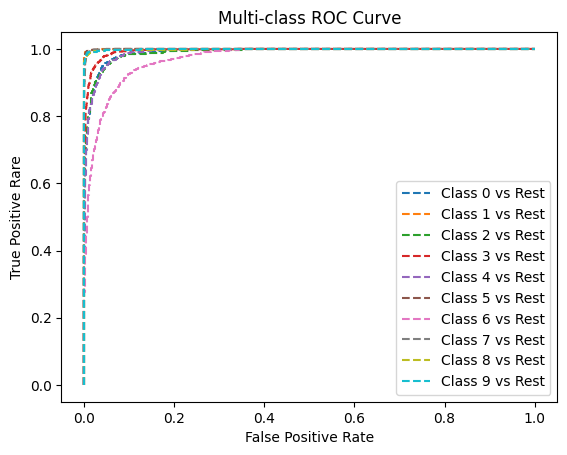

auc_score : 0.9931041944444445


In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr ={}
tpr ={}
thresh = {}
n_class =10

for i in range(n_class):
  fpr[i], tpr[i], thresh[i] =roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label =i) #class별로 따로따로

#plot
for i in range(n_class):
  plt.plot(fpr[i], tpr[i], linestyle ='--', label=f'Class {i} vs Rest')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rare')
plt.legend(loc ='best')
plt.show()

auc_score = roc_auc_score(test_labels_list, test_outputs_list, multi_class ='ovo', average ='macro')
print(f'auc_score : {auc_score}')